# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Correlations](#correlations)


. [Correlations](#correlations)


In [1]:
# Import necessary libraries
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns


## Dataset Overview

[Provide a high-level overview of the dataset. This should include the source of the dataset, the number of samples, the number of features, and example showing the structure of the dataset.]


In [39]:

# Load the NAO daily dataset
url = "https://ftp.cpc.ncep.noaa.gov/cwlinks/norm.daily.nao.cdas.z500.19500101_current.csv"
df = pd.read_csv(url)

# Clean and index time
df['time'] = pd.to_datetime(df[['year','month','day']])
df = df.set_index('time')

# cyclic encoding
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# Feature Engineering: Seasonality and Decades
# Winter (Nov-Apr) vs Summer (May-Oct)
winter_months = {11, 12, 1, 2, 3, 4}
df['season_flag'] = df['month'].apply(lambda m: 1 if m in winter_months else -1)
df['decade'] = df['year'] // 10 * 10

# Drop redundant columns
df.drop(columns=['day', 'year'], inplace=True)

# Convert to xarray for professional climate data handling
ds = xr.Dataset.from_dataframe(df)

# Number of samples
num_samples = df.shape[0]

# Number of features
num_features = df.shape[1]

# Display these dataset characteristics
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")

# Display the first few rows of the dataframe to show the structure
print("Example data:")
print(df.head())

Number of samples: 27770
Number of features: 6
Example data:
            month  nao_index_cdas  month_sin  month_cos  season_flag  decade
time                                                                        
1950-01-01      1           0.365        0.5   0.866025            1    1950
1950-01-02      1           0.096        0.5   0.866025            1    1950
1950-01-03      1          -0.416        0.5   0.866025            1    1950
1950-01-04      1          -0.616        0.5   0.866025            1    1950
1950-01-05      1          -0.261        0.5   0.866025            1    1950


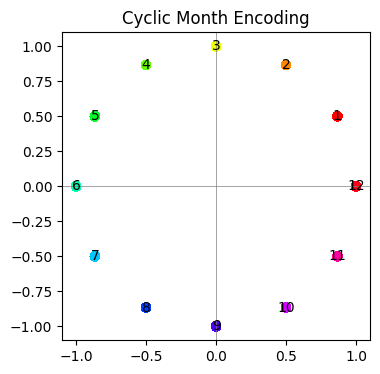

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
plt.scatter(df["month_cos"], df["month_sin"], c=df["month"], cmap="hsv")
for m in range(1, 13):
    x = np.cos(2 * np.pi * m / 12)
    y = np.sin(2 * np.pi * m / 12)
    plt.text(x, y, str(m), ha="center", va="center")

plt.axhline(0, color="gray", lw=0.5)
plt.axvline(0, color="gray", lw=0.5)
plt.gca().set_aspect("equal")
plt.title("Cyclic Month Encoding")
plt.show()


## Handling Missing Values

[Identify any missing values in the dataset, and describe your approach to handle them if there are any. If there are no missing values simply indicate that there are none.]


In [3]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values


,0
month,0
nao_index_cdas,2
season_flag,0
decade,0


In [9]:
# Handling missing values
# Example: Replacing NaN values with the mean value of the column
# df.fillna(df.mean(), inplace=True)

# Your code for handling missing values goes here

#fill NaNs with mean of theire neighboring values?

def fill_nans_weighted(ds, dim, n=3, weights=None):
    """
    Fill NaNs in an xarray Dataset/DataArray using a weighted mean of
    n values before and after along dimension `dim`.

    Parameters
    ----------
    ds : xr.DataArray or xr.Dataset
        Input data with NaNs to fill.
    dim : str
        Dimension along which to apply the interpolation (e.g. "time").
    n : int
        Number of values before and after to use.
    weights : array-like or None
        Weights for the window. Should have length (2*n + 1).
        If None, all weights = 1 (simple mean).

    Returns
    -------
    xr.DataArray or xr.Dataset
        Data with NaNs filled.
    """

    window = 2 * n + 1

    # default: equal weights
    if weights is None:
        weights = np.ones(window)
    else:
        weights = np.asarray(weights)
        if len(weights) != window:
            raise ValueError("weights must have length 2*n + 1")

    # Normalize weights
    weights = weights / weights.sum()

    # Rolling window with centered window
    rolled = ds.rolling({dim: window}, center=True).construct("window")

    # Weighted mean ignoring NaNs
    filled = (rolled * xr.DataArray(weights, dims=["window"])).sum("window")

    # Replace NaNs only
    return ds.fillna(filled)

ds = fill_nans_weighted(ds, dim='time', n=3, weights=None)

# different means
ds_weekly  = ds.resample(time="W").mean()
ds_monthly = ds.resample(time="MS").mean()
ds_monthly

ds_yearly = ds.resample(time="YS").mean()
ds_yearly

ds_decade = ds.resample(time="10YS").mean()
ds_decade

# Convert to pandas DataFrame
df_monthly = ds_monthly.to_dataframe()
df_monthly

,month,nao_index_cdas,season_flag,decade
time,,,,
1950-01-01,1.0,0.463516,1.0,1950.0
1950-02-01,2.0,0.420714,1.0,1950.0
1950-03-01,3.0,0.008387,1.0,1950.0
1950-04-01,4.0,0.239433,1.0,1950.0
1950-05-01,5.0,-0.261226,-1.0,1950.0
...,...,...,...,...
2025-09-01,9.0,-0.373873,-1.0,2020.0
2025-10-01,10.0,-0.398225,-1.0,2020.0
2025-11-01,11.0,-0.434436,1.0,2020.0


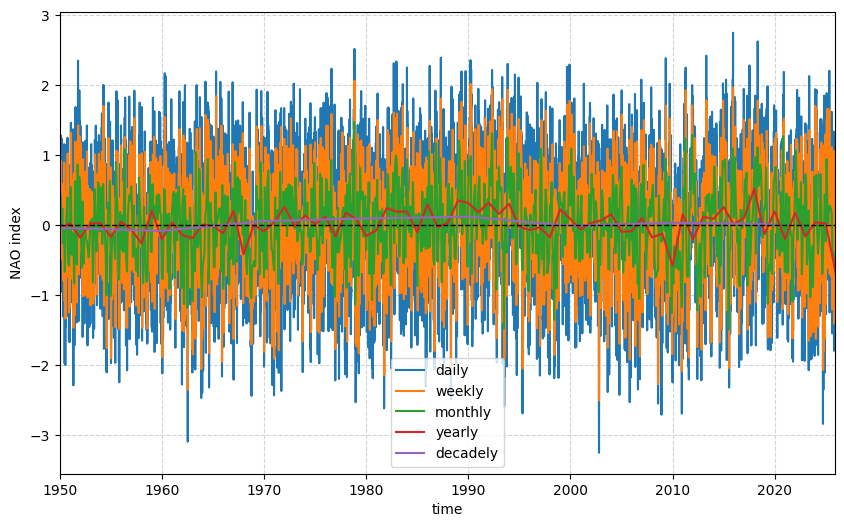

In [11]:
#plot data to see which mean to take -> monthly
#also selection of features done whith this, decadal stuff seems to be important, further check seasonality
plt.figure(figsize=(10,6))
plt.plot(ds.time, ds.nao_index_cdas, label = 'daily')
plt.plot(ds_weekly.time, ds_weekly.nao_index_cdas, label = 'weekly')
plt.plot(ds_monthly.time, ds_monthly.nao_index_cdas, label='monthly')
plt.plot(ds_yearly.time, ds_yearly.nao_index_cdas, label = 'yearly')
plt.plot(ds_decade.time, ds_decade.nao_index_cdas, label = 'decadely')
plt.xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2025-11-21')) ###!!! needs to be corrected to today!!!
plt.hlines(y=0, xmin=pd.Timestamp('1950-01-01'), xmax=pd.Timestamp('2025-12-31'), linestyle='--', color='black', linewidth=1)
plt.grid(linestyle = '--', color = 'lightgrey')
plt.xlabel('time')
plt.ylabel('NAO index')
plt.legend()
plt.show()
#plt.xlim(pd.Timestamp('1980-01-01'), pd.Timestamp('1990-01-01'))

/usr/local/lib/python3.12/dist-packages/xarray/structure/concat.py:673: UserWarning: No index created for dimension month because variable month is not a coordinate. To create an index for month, please first call `.set_coords('month')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


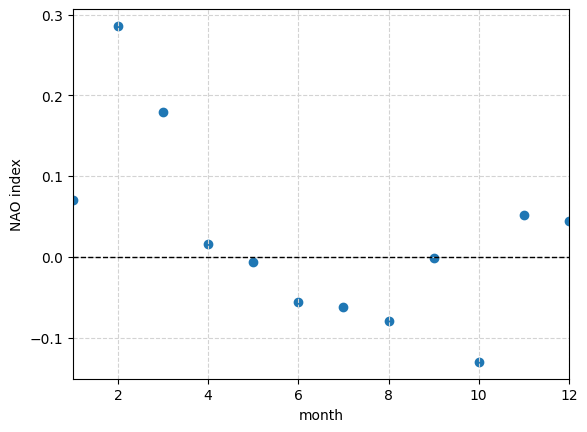

In [12]:
#is there a seasonality? -> yes, take seasonality also as feature
climatology = ds.groupby("time.month").mean("time")

plt.scatter(climatology.month, climatology.nao_index_cdas)
plt.grid(linestyle = '--', color = 'lightgrey')
plt.xlabel('month')
plt.ylabel('NAO index')
plt.hlines(y=0, xmin=1, xmax=12, linestyle='--', color='black', linewidth=1)
plt.xlim(1,12)
plt.show()

## Feature Distributions

[Plot the distribution of various features and target variables. Comment on the skewness, outliers, or any other observations.]


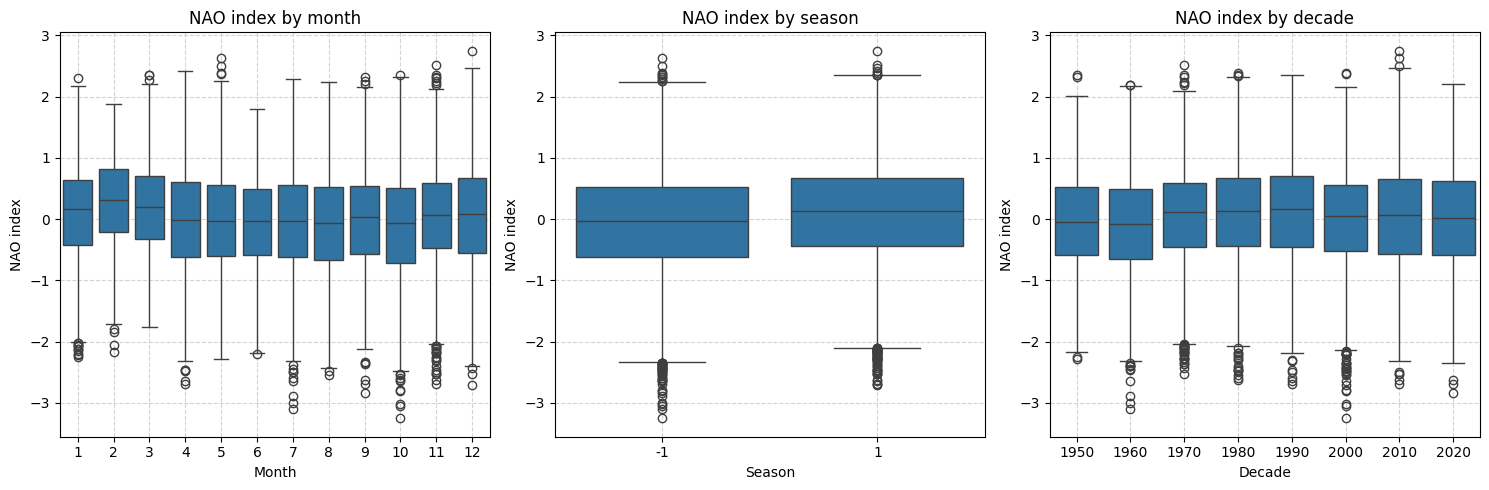

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=df, x='month', y='nao_index_cdas', ax=ax[0])
ax[0].set_title("NAO index by month")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("NAO index")

sns.boxplot(data=df, x='season_flag', y='nao_index_cdas', ax=ax[1])
ax[1].set_title("NAO index by season")
ax[1].set_xlabel("Season")
ax[1].set_ylabel("NAO index")

sns.boxplot(data=df, x='decade', y='nao_index_cdas', ax=ax[2])
ax[2].set_title("NAO index by decade")
ax[2].set_xlabel("Decade")
ax[2].set_ylabel("NAO index")

for i in range(0,3):
    ax[i].grid(linestyle = '--', color = 'lightgrey')
plt.tight_layout()
plt.show()

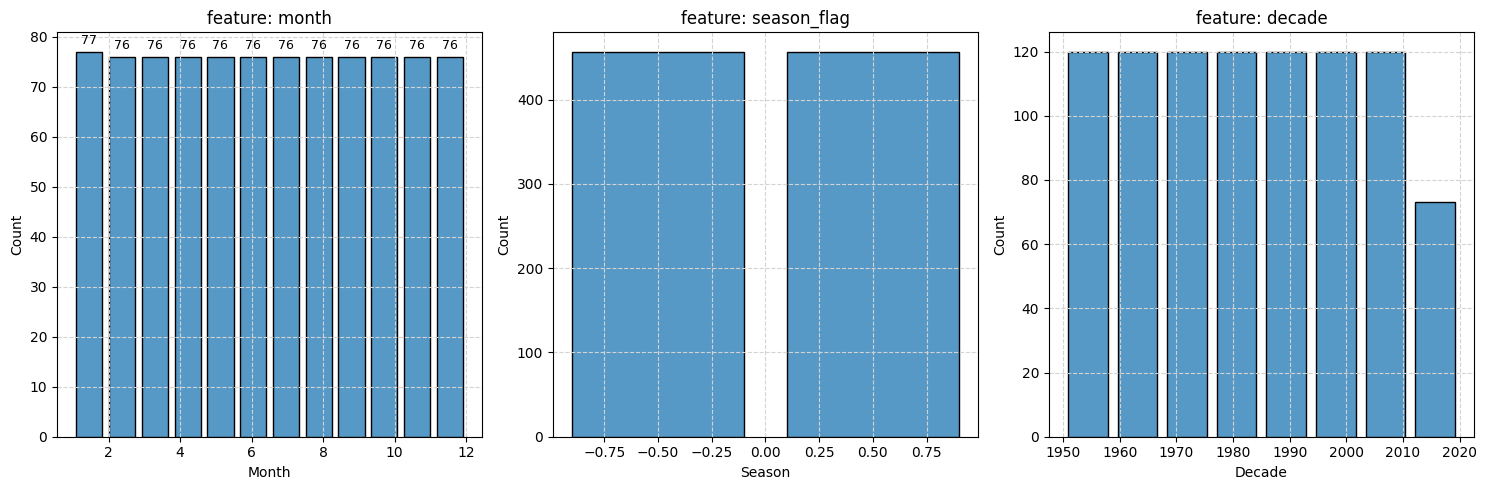

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(ds_monthly.month, bins=12, kde=False,shrink=0.8, label = 'data', ax=ax[0])
ax[0].set_title("feature: month")
ax[0].set_xlabel("Month")
# Add counts on top of bars
for p in ax[0].patches:
    height = p.get_height()
    if height > 0:
        ax[0].annotate(
            f'{int(height)}',
            (p.get_x() + p.get_width() / 2., height),
            ha='center',
            va='bottom',
            fontsize=9,
            xytext=(0, 3),
            textcoords='offset points'
        )
sns.histplot(ds_monthly.season_flag, bins=2, kde=False,shrink=0.8, label = 'data', ax=ax[1])
ax[1].set_title("feature: season_flag")
ax[1].set_xlabel("Season")

sns.histplot(ds_monthly.decade, bins=8, kde=False,shrink=0.8, label = 'data', ax=ax[2])
ax[2].set_title("feature: decade")
ax[2].set_xlabel("Decade")

for i in range(0,3):
    ax[i].grid(linestyle = '--', color = 'lightgrey')
plt.tight_layout()
plt.show()

The data is up to today, by this the current decade, the season and the months (depending on todays date) is underrepresented /overrepresented.

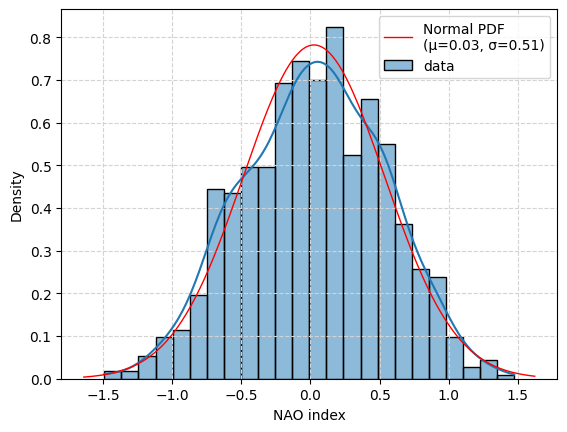

Skewness: -0.07066064573654961


In [16]:
sns.histplot(ds_monthly.nao_index_cdas, bins=24, kde=True, stat="density", label = 'data')
plt.grid(linestyle = '--', color = 'lightgrey')
plt.xlabel('NAO index')

from scipy.stats import norm
# Compute normal distribution curve
x = ds_monthly.nao_index_cdas
mu = x.mean()
sigma = x.std()
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 300)
yy = norm.pdf(xx, mu, sigma)

# Plot normal curve
plt.plot(xx, yy, 'r-', linewidth=1, label=f'Normal PDF \n(μ={mu:.2f}, σ={sigma:.2f})')

plt.legend(loc = 'upper right')
plt.show()

# Compute skewness
from scipy.stats import skew
sk = skew(ds_monthly.nao_index_cdas.values, nan_policy='omit')
print("Skewness:", sk)

## Possible Biases

[Investigate the dataset for any biases that could affect the model’s performance and fairness (e.g., class imbalance, historical biases).]


Summary Statistics:

count    27768.000000
mean         0.024469
std          0.816544
min         -3.254000
25%         -0.532000
50%          0.056000
75%          0.605000
max          2.751319
Name: nao_index_cdas, dtype: float64




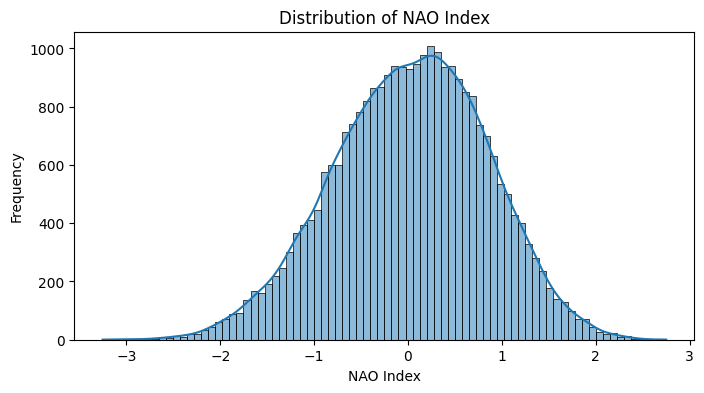

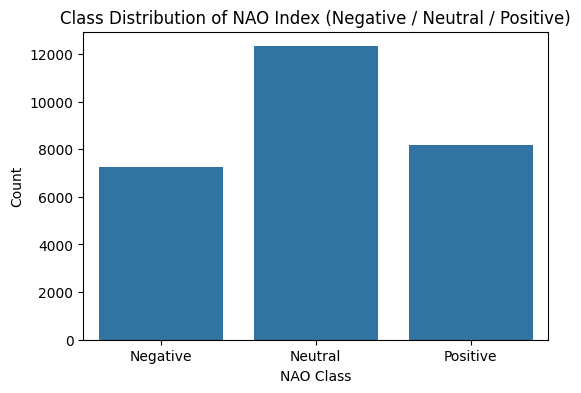


Class Counts:
nao_class
Neutral     12318
Positive     8177
Negative     7273
Name: count, dtype: int64




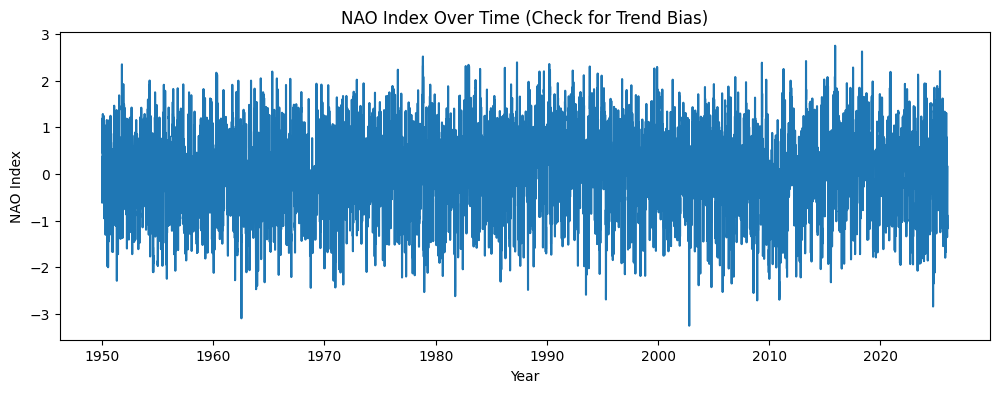

In [17]:
# Example: Checking for class imbalance in a classification problem
# sns.countplot(x='target_variable', data=df)


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

url = "https://ftp.cpc.ncep.noaa.gov/cwlinks/norm.daily.nao.cdas.z500.19500101_current.csv"
df = pd.read_csv(url)

# 1. Basic Summary Statistics (checks for skew, imbalance, outliers)
print("Summary Statistics:\n")
print(df['nao_index_cdas'].describe())
print("\n")

# 2. Check Distribution Shape (important for bias in regression)
plt.figure(figsize=(8, 4))
sns.histplot(df['nao_index_cdas'], kde=True)
plt.title("Distribution of NAO Index")
plt.xlabel("NAO Index")
plt.ylabel("Frequency")
plt.show()

# 3. Convert Continuous Target into Classes (for class imbalance check)
df['nao_class'] = pd.cut(
    df['nao_index_cdas'],
    bins=[-999, -0.5, 0.5, 999],
    labels=['Negative', 'Neutral', 'Positive']
)


# 4. Class Imbalance Plot
plt.figure(figsize=(6, 4))
sns.countplot(x='nao_class', data=df)
plt.title("Class Distribution of NAO Index (Negative / Neutral / Positive)")
plt.xlabel("NAO Class")
plt.ylabel("Count")
plt.show()

# Optional: Print class counts
print("\nClass Counts:")
print(df['nao_class'].value_counts())
print("\n")

# 5. Temporal Bias Check (climate data often shifts over decades)
df['date'] = pd.to_datetime(df[['year','month','day']])

plt.figure(figsize=(12, 4))
sns.lineplot(x='date', y='nao_index_cdas', data=df)
plt.title("NAO Index Over Time (Check for Trend Bias)")
plt.xlabel("Year")
plt.ylabel("NAO Index")
plt.show()

## Correlations

[Explore correlations between features and the target variable, as well as among features themselves.]


### Autocorrelation

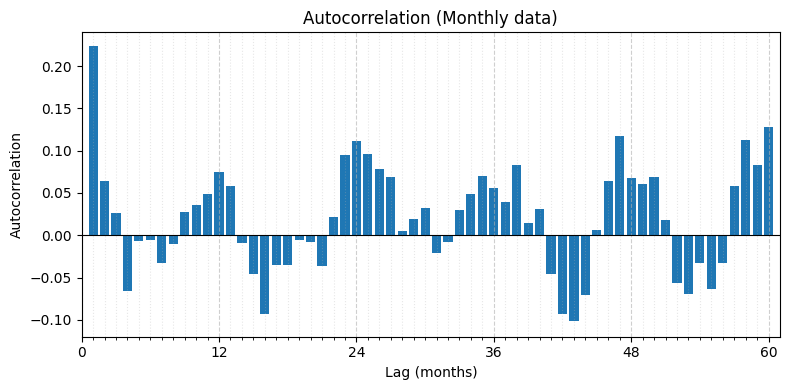

In [33]:
series = df_monthly["nao_index_cdas"].dropna()
n_lags = 60

acf = [series.autocorr(lag=i) for i in range(1, n_lags + 1)]

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(1, n_lags + 1), acf, width=0.8)

ax.axhline(0, color='black', linewidth=0.8)
ax.set_xlabel("Lag (months)")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation (Monthly data)")
#plt.vlines(x=12, ymax=0.24, ymin=-0.13, color = 'k')
#plt.vlines(x=24, ymax=0.24, ymin=-0.13, color = 'k')
#plt.vlines(x=3*12, ymax=0.24, ymin=-0.13, color = 'k')
#plt.vlines(x=4*12, ymax=0.24, ymin=-0.13, color = 'k')
#plt.vlines(x=5*12, ymax=0.24, ymin=-0.13, color = 'k')
plt.ylim(-0.12,0.24)
plt.xlim(0,61)
# monthly minor grid
ax.set_xticks(range(0, 61, 1), minor=True)
# yearly major grid
ax.set_xticks(range(0, 61, 12))
ax.grid(which="minor", axis="x", linestyle=":", alpha=0.3)
ax.grid(which="major", axis="x", linestyle="--", alpha=0.6)#

plt.tight_layout()
plt.show()


### Check correlation of winter with previous month

In [36]:
# example variable
da = ds_monthly["nao_index_cdas"]

# define winter mean (DJF), assigned to Jan year
winter = (
    da
    .where(da["time.month"].isin([12, 1, 2]), drop=True)
    .groupby("time.year")
    .mean()
)

# monthly means by calendar month
# monthly = da.groupby("time.month") # This line is no longer directly used in the problematic part

# correlate each month with following winter
corr = xr.concat(
    [
        xr.corr(da.sel(time=da['time.month'] == m).shift(time=-1).groupby("time.year").mean(), winter, dim='year')
        for m in range(1, 13)
    ],
    dim="month"
)

corr["month"] = np.arange(1, 13)


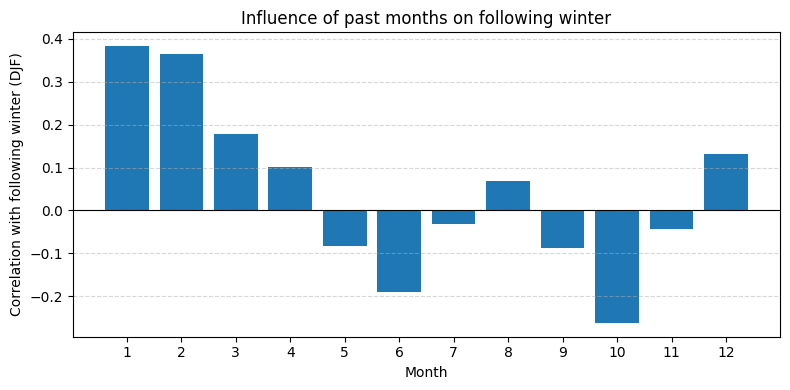

In [37]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(corr.month, corr, width=0.8)

ax.axhline(0, color="black", linewidth=0.8)
ax.set_xticks(range(1, 13))
ax.set_xlabel("Month")
ax.set_ylabel("Correlation with following winter (DJF)")
ax.set_title("Influence of past months on following winter")

ax.grid(True, axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


The previous winter has a high correlation with the following, eighter just due to seasonality, but maybe also due to some signal preserving or ocean memory.
A relativly high but negative correlation is visible for october. So high positive NAO indexes during october could give a hint, that the following winter will have a high negative NAO index coming along with cold winters in northern Europe.